In [1]:
import numpy as np
import xarray as xr
import extremespaper as ex
import viz
import mplRC
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cftime
import datetime as dt
import os
import glob
import matplotlib.cm as mcm

mplRC.paperRC2()

/home/ords/crd/ccrn/reo000/mamba_files/envs/mpy39dc/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


#### start with temperature events relative to historical ~1995 level (midpoint of historical slice), no adaptation
A) historical 95th percentile extreme days, non-seasonal definition, raw basis (relative to 1985-2014)

C) historical 95th percentile extreme days, seasonal definition, raw basis (relative to 1985-2014)

E) 40-year window MMMm running mean (~95th percentile) threshold, non-seasonal (relative to previous 40 years)

In [2]:
qq=.98
freq='daily'
chdef0={'time':-1,'lat':90,'lon':90}
scenNameref='ESM4_historical_D1'
yrspanref=ex.dictScenDates[scenNameref]
dirstr={1:'max',-1:'min'}

vstrs={'tos':'SST',
       'hplusos':'Surface H$^+$',
       'omega_arag_0':'Surface $\Omega _{arag}$',
       'spco2':'Surface pCO$_2$'}
# vstrs2={'tos':'SST',
#        'hplusos':'Surface H$\bf{^+}$',
#        'omega_arag_0':'Surface $\bf{ \Omega _{arag}$}',
#        'o2_mean_100_600':'100-600m Mean O$\bf _2$',
#        'spco2':'Surface pCO2'}

In [3]:
ff={}
sf={}
for ivar in ['tos','hplusos','omega_arag_0','spco2']:
    exdir=ex.exdirs[ivar]
    quant=qq if exdir==1 else np.round(1-qq,2)
    qstring=f"p{quant*100}"
    print(ivar,exdir)
    sf[ivar]=xr.open_dataset(ex.fNameStatsFile('ESM4_historical_D1',
                                               ex.dictScenDates['ESM4_historical_D1'],'daily',ivar))
    for iscen in ['ESM4_historical_D1','ESM4_ssp126_D1','ESM4_ssp370_D1']:
        yrspan=ex.dictScenDates[iscen]
        fp0=ex.exstats_path(ivar,iscen,yrspan,scenNameref,yrspanref,freq,exdir,quant,calcDurAmp=False,grid='1x1')
        if os.path.exists(fp0):
            ff[(ivar,iscen)]=xr.open_dataset(fp0)
            print(fp0)
        else:
            raise Exception(f'file missing: {fp0}')

tos 1
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_historical_D1.1975_2014.refESM4_historical_D1.1975_2014.daily.tos.max.p98.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_ssp126_D1.2061_2100.refESM4_historical_D1.1975_2014.daily.tos.max.p98.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_ssp370_D1.2061_2100.refESM4_historical_D1.1975_2014.daily.tos.max.p98.0.1x1.nc
hplusos 1
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_historical_D1.1975_2014.refESM4_historical_D1.1975_2014.daily.hplusos.max.p98.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_ssp126_D1.2061_2100.refESM4_historical_D1.1975_2014.daily.hplusos.max.p98.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/cal

In [4]:
hist='ESM4_historical_D1'
s126='ESM4_ssp126_D1'
s370='ESM4_ssp370_D1'

In [5]:
proj=ccrs.Robinson(central_longitude=-150)#-170
lons=viz.lonvec1x1
lats=viz.latvec1x1

In [6]:
def plot_sns(ax,axti,ivar,cbax=None):
    cmin=1/(365*40)*100

    ax[0,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0|ff[ivar,s126]['is_exA_sum'],
                                                    ff[ivar,s126]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)

    m=ax[0,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    if ivar=='tos':
        with xr.open_dataset(ex.fNameStatsFile(scenNameref,ex.dictScenDates[scenNameref],freq,ivar)) as sf:
            ax[0,1].contour(lons,lats,sf['seas'].max(dim='YD'),[1,],colors='w',linewidths=.8,linestyles=':',transform=ccrs.PlateCarree())
    elif ivar=='hplusos':
        with xr.open_dataset(ex.fNameStatsFile(scenNameref,ex.dictScenDates[scenNameref],freq,ivar)) as sf:
            ax[0,0].contour(lons,lats,sf['seas'].max(dim='YD'),[.0007,],colors='w',linewidths=.8,linestyles=':',transform=ccrs.PlateCarree())
    elif ivar=='omega_arag_0':
        with xr.open_dataset(ex.fNameStatsFile(scenNameref,ex.dictScenDates[scenNameref],freq,ivar)) as sf:
            ax[0,0].contour(lons,lats,sf['seas'].min(dim='YD'),[-.15,],colors='w',linewidths=.8,linestyles=':',transform=ccrs.PlateCarree())
    elif ivar=='spco2':
        with xr.open_dataset(ex.fNameStatsFile(scenNameref,ex.dictScenDates[scenNameref],freq,ivar)) as sf:
            ax[0,0].contour(lons,lats,sf['seas'].max(dim='YD'),[4.05,],colors='w',linewidths=.8,linestyles=':',transform=ccrs.PlateCarree())
    if cbax: fig.colorbar(mcm.ScalarMappable(norm=mcolors.Normalize(vmin=0,vmax=100), cmap=viz.cm1b),cax=cbax); cbax.set_title('%') #fig.colorbar(m,cax=cbax); cbax.set_title('%')
    ax[1,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[1,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    #     fig.suptitle(f'Extreme Event Days, No Adaptation, raw 1985-2014 95/5 reference,'
    #                  f'{vstrs[ivar]}',y=1.03)

    for iax in (ax[0,0],ax[0,1],ax[1,0],ax[1,1]):
        iax.set_xticks([])
        iax.set_yticks([])
    ax[0,0].set_title('SSP1-2.6',pad=3)
    ax[0,1].set_title('SSP3-7.0',pad=3)
    ax[0,0].set_ylabel('SC',labelpad=1)
    ax[1,0].set_ylabel('SV',labelpad=1)
    axti.set_title(vstrs[ivar],pad=10)
    return


In [7]:
4.05/101325*1e6

39.970392301998515

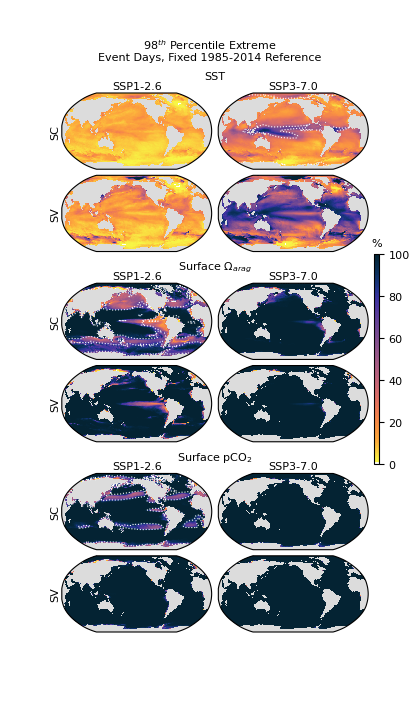

In [8]:
fig = plt.figure(figsize=(4, 7), constrained_layout=False)
og = fig.add_gridspec(3, 1, wspace=.08, hspace=.2)
axs={}
axt={}
iii=0
for b in range(3):
        # gridspec inside gridspec
        ig = og[b].subgridspec(2, 2, wspace=0.02, hspace=0.08)
        axs[iii] = ig.subplots(subplot_kw={'projection':proj,'facecolor':'gainsboro'})
        axt[iii]=fig.add_subplot(og[b])
        axt[iii].axis('off')
        iii+=1
cbax=fig.add_axes([.91,.35,.012,.3])
rd='$^{th}$'
fig.suptitle(f'{int(qq*100)}{rd} Percentile Extreme\nEvent Days, Fixed 1985-2014 Reference',y=.96)

plot_sns(axs[0],axt[0],'tos',cbax)
plot_sns(axs[1],axt[1],'omega_arag_0')
#plot_sns(axs[2],axt[2],'hplusos')
plot_sns(axs[2],axt[2],'spco2')

axa=fig.add_axes(rect=[0,0,1,1])
axa.set_axis_off()
# axa.annotate('(a)',xy=(0.12, 0.872))
# axa.annotate('(b)',xy=(0.52, 0.872))
# axa.annotate('(c)',xy=(0.12, 0.755))
# axa.annotate('(d)',xy=(0.52, 0.755))
# axa.annotate('(e)',xy=(0.12, 0.60))
# axa.annotate('(f)',xy=(0.52, 0.60))
# axa.annotate('(g)',xy=(0.12, 0.485))
# axa.annotate('(h)',xy=(0.52, 0.485))
# axa.annotate('(i)',xy=(0.12, 0.33))
# axa.annotate('(j)',xy=(0.52, 0.33))
# axa.annotate('(k)',xy=(0.12, 0.21))
# axa.annotate('(l)',xy=(0.52, 0.21))

fig.savefig(f'global_extremes_seas_All_newcm_{int(qq*100)}.png',dpi=300,bbox_inches='tight')

In [9]:

def plot_snsAdapt(ax,axti,ivar,cbax=None):
    cmin=1/(40*365)
    ax[0,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    ax[0,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[0,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    if cbax: fig.colorbar(mcm.ScalarMappable(norm=mcolors.Normalize(vmin=0,vmax=100), cmap=viz.cm1b),cax=cbax); cbax.set_title('%')
    ax[1,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exG100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    ax[1,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exG100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[1,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exG100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)

    #fig.suptitle(f'Extreme Event Days, 100-year Adaptation, raw 1985-2014 95/5 reference,'
    #             f'{vstrs[ivar]}',y=1.02)
    for iax in (ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]):
        iax.set_xticks([])
        iax.set_yticks([])
    ax[0,0].set_title('Historical',pad=3)
    ax[0,1].set_title('SSP1-2.6',pad=3)
    ax[0,2].set_title('ssp3-7.0')
    ax[0,0].set_ylabel('SC',labelpad=3)
    ax[1,0].set_ylabel('SV',labelpad=3)
    axti.set_title(vstrs[ivar],pad=13)#,loc='left')
    return

In [ ]:
fig = plt.figure(figsize=(6.2, 7), constrained_layout=False)
og = fig.add_gridspec(3, 1, wspace=.08, hspace=.22)
axs={}
axt={}
iii=0
for b in range(3):
    # gridspec inside gridspec
    ig = og[b].subgridspec(2, 3, wspace=0.02, hspace=0.08)
    axs[iii] = ig.subplots(subplot_kw={'projection':proj,'facecolor':'gainsboro'})
    axt[iii]=fig.add_subplot(og[b])
    axt[iii].axis('off')
    iii+=1
cbax=fig.add_axes([.91,.65,.012,.23])

fig.suptitle(f'98{rd} Percentile Extreme\nEvent Days, 100-year Adaptive Reference',y=.96)

plot_snsAdapt(axs[0],axt[0],'tos',cbax)
plot_snsAdapt(axs[1],axt[1],'omega_arag_0')
plot_snsAdapt(axs[2],axt[2],'spco2')

axa=fig.add_axes(rect=[0,0,1,1])
axa.set_axis_off()
# axa.annotate('(a)',xy=(0.13, 0.872))
# axa.annotate('(b)',xy=(0.39, 0.872))
# axa.annotate('(c)',xy=(0.65, 0.872))
# axa.annotate('(d)',xy=(0.13, 0.758))
# axa.annotate('(e)',xy=(0.39, 0.758))
# axa.annotate('(f)',xy=(0.65, 0.758))
# axa.annotate('(g)',xy=(0.13, 0.60))
# axa.annotate('(h)',xy=(0.39, 0.60))
# axa.annotate('(i)',xy=(0.65, 0.60))
# axa.annotate('(j)',xy=(0.13, 0.482))
# axa.annotate('(k)',xy=(0.39, 0.482))
# axa.annotate('(l)',xy=(0.65, 0.482))
# axa.annotate('(m)',xy=(0.13, 0.33))
# axa.annotate('(n)',xy=(0.39, 0.33))
# axa.annotate('(o)',xy=(0.65, 0.33))
# axa.annotate('(p)',xy=(0.13, 0.21))
# axa.annotate('(q)',xy=(0.39, 0.21))
# axa.annotate('(r)',xy=(0.65, 0.21))
fig.savefig('global_extremes_seasAdapt_All_newcm_98.png',dpi=300,bbox_inches='tight')